In [ ]:
install.packages('tseries')

### Dataset de vôos. Previsão de vôos cancelados

# Ler dados, grafico de dispersao

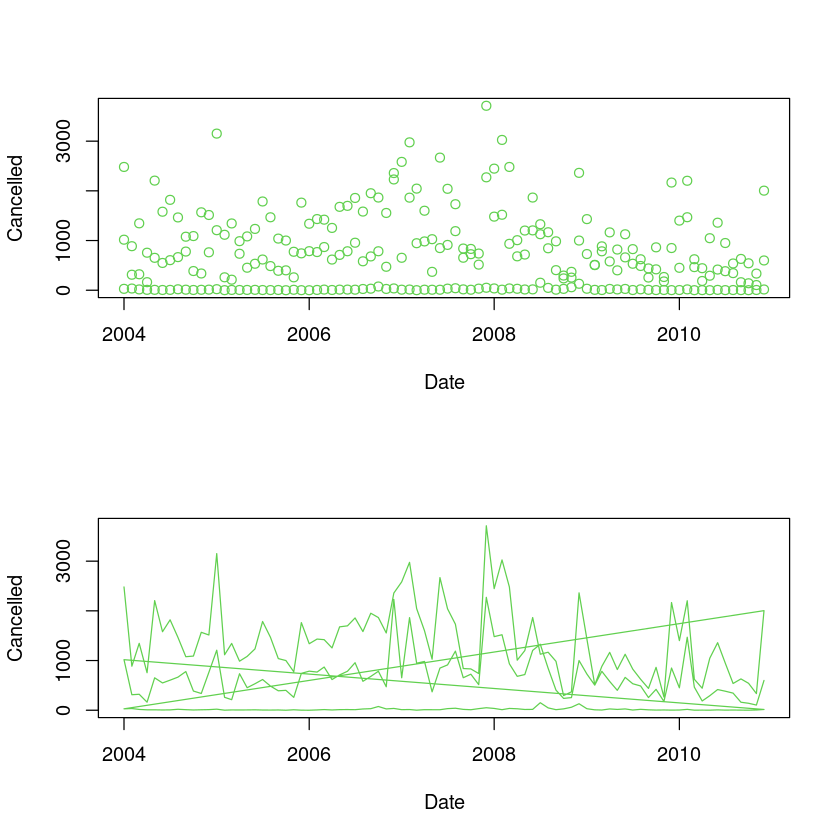

In [4]:
require (tseries)
dados=read.table("baggagecomplaints.csv",header=T,sep=",")
# Ler data corretamente de acordo com formato
dados$Date = as.Date(paste("01/", dados$Date, sep = ""), format = "%d/%m/%Y")
attach(dados)
par(mfrow = c(2, 1))
plot(dados$Date, dados$Cancelled, col="3",xlab="Date", ylab="Cancelled")
plot(dados$Date, dados$Cancelled, type="l", col="3",xlab="Date", ylab="Cancelled")

# Decomposicao STL
- Sazonalidade: flutuações recorrentes e previsíveis em um dataset.
- Tendência: direção a longo prazo.
- Resíduos: correspondente a possíveis erros de medição ou eventos aleatórios.

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2004,7.816417,6.786717,7.204893,6.626718,7.698936,7.365180,7.506042,7.289611,6.981935,6.993933,7.357556,7.322510
2005,8.055792,7.017506,7.203406,6.894670,6.987490,7.118016,7.487734,7.291656,6.946014,6.907755,6.651572,7.474772
2006,7.198931,7.266827,7.258412,7.134094,7.425358,7.437206,7.526718,7.367077,7.576610,7.531016,7.349231,7.765569
2007,7.856707,7.998335,7.623153,7.377759,6.934397,7.889459,7.621195,7.456455,6.732211,6.722630,6.603944,8.219326
2008,7.802618,8.014666,7.816417,6.914731,7.090910,7.531016,7.027315,7.062192,6.891626,5.686975,5.913503,7.767264
2009,7.266129,6.236370,6.783325,7.059618,6.708084,7.026427,6.717805,6.434547,6.084499,6.760415,5.583496,7.681099
2010,7.244942,7.697575,6.434547,6.093570,6.953684,7.214504,6.856462,6.287859,6.445720,6.295266,5.814131,7.602900


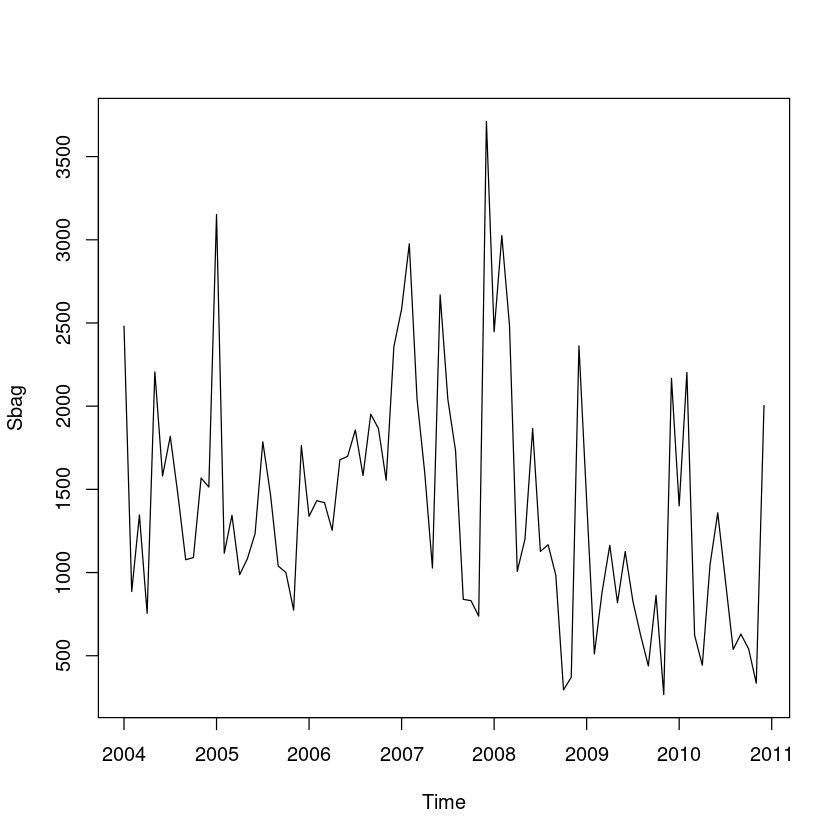

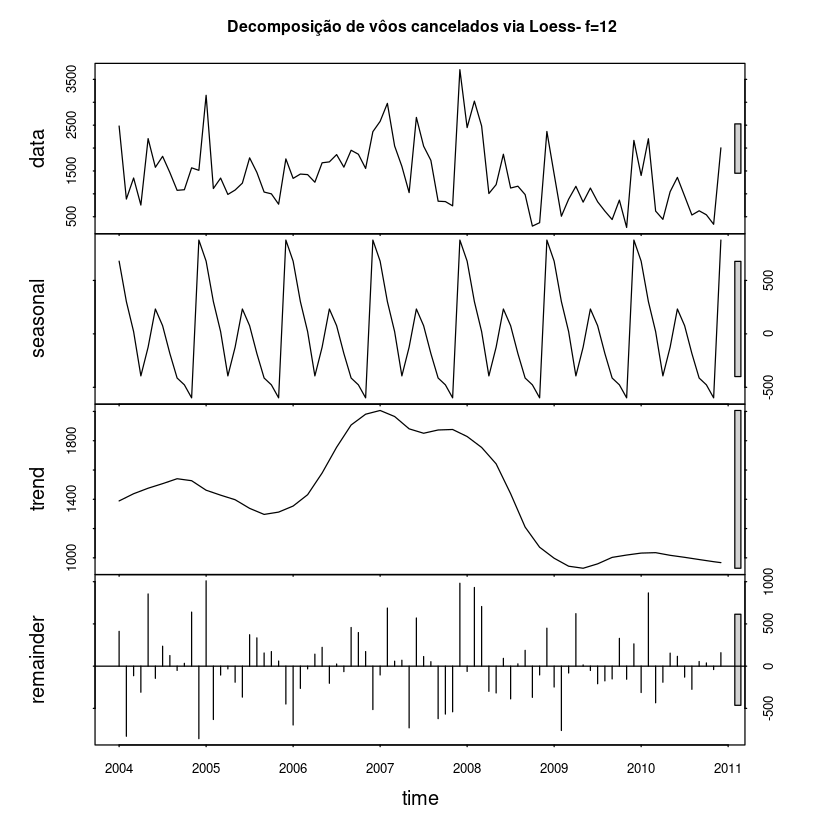

In [9]:
# Ajuste com base nas datas iniciais e finais
Sbag<-ts(Cancelled,frequency=12, start = c(min(Year), min(Month)), end = c(max(Year), max(Month)))
# Sbag
plot(Sbag)
# log(Sbag)
plot(stl(Sbag, s.window="periodic"),main=" Decomposição de vôos cancelados via Loess- f=12")

# FAC/ACF: Função de Autocorrelação

### Determinar valores de FAC
- Identificar a necessidade de retirar a sazonalidade
   - Por que retirar a sazonalidade? Método ARIMA supõe dados estacionários,
   porque assim a média, variância e covariância são constantes.

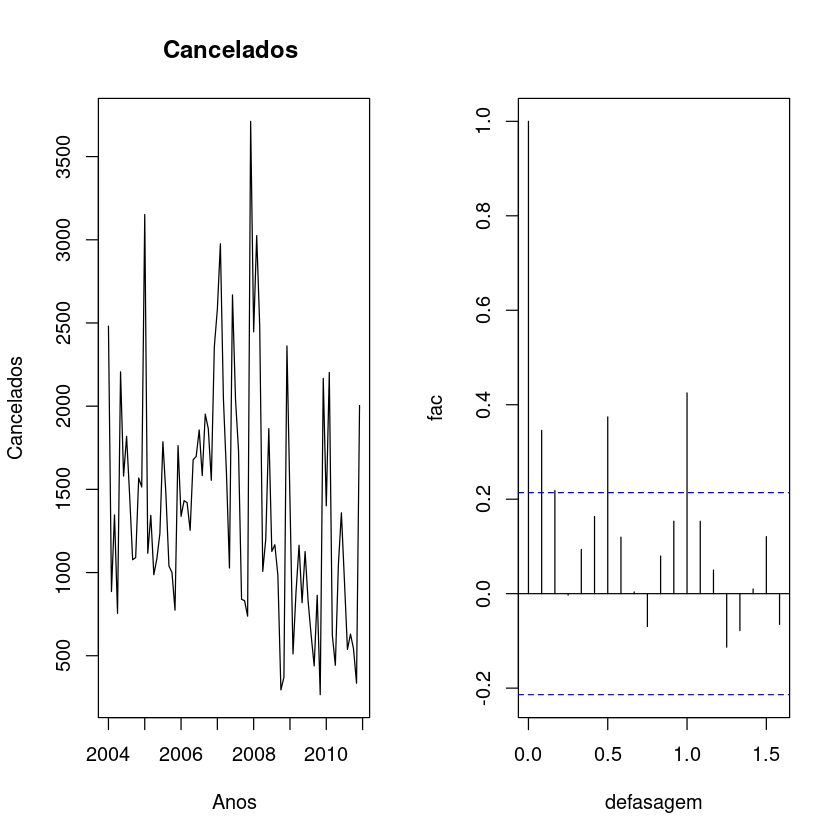

In [10]:
par(mfrow=c(1,2))
plot(Sbag,main='Cancelados ',xlab='Anos',ylab='Cancelados')
acf (Sbag,xlab='defasagem',ylab='fac',main='',na.action=na.pass)

### Diferenciação
- Remover sazonalidade (induzir estacionaridade) na série
- Lag: deslocamento de valores a fim de aproximar valores passados de futuros,
com o objetivo de facilitar a previsão.

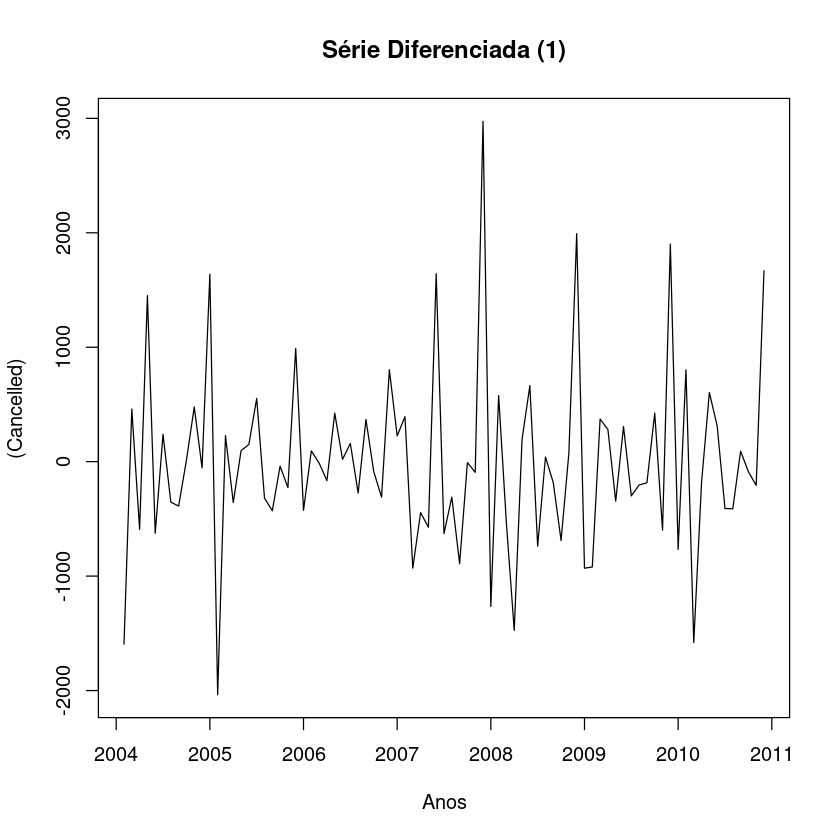

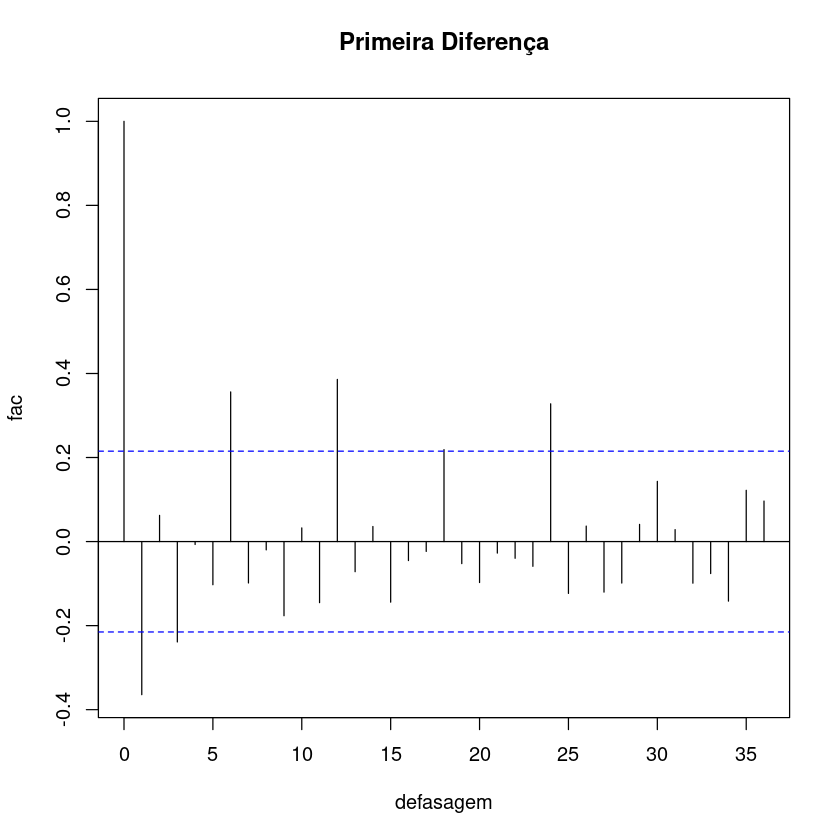

In [11]:
plot(diff(Sbag),main='Série Diferenciada (1)',xlab='Anos',ylab=' (Cancelled) ')
min.m = acf(diff(Sbag),lag.max=36, plot=F, na.action=na.pass)
min.m$lag = min.m$lag*12
plot(min.m, main = 'Primeira Diferença', xlab='defasagem',ylab='fac')

### Gráficos até agora

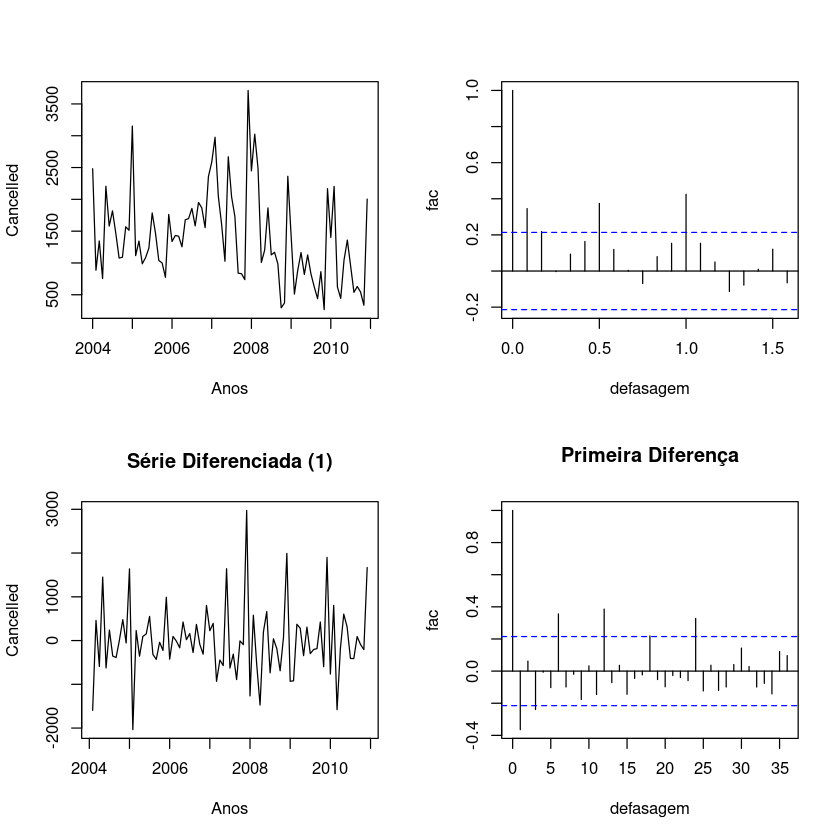

In [12]:
par(mfrow=c(2,2))
plot(Sbag,main='',xlab='Anos',ylab='Cancelled')
acf (Sbag,xlab='defasagem',ylab='fac',main='',na.action=na.pass)
plot(diff(Sbag),main='Série Diferenciada (1)',xlab='Anos',ylab=' Cancelled ')
min.m = acf(diff(Sbag),lag.max=36, plot=F, na.action=na.pass)
min.m$lag = min.m$lag*12
plot(min.m, main = 'Primeira Diferença', xlab='defasagem',ylab='fac')

### Diferenciação simples e sazonal

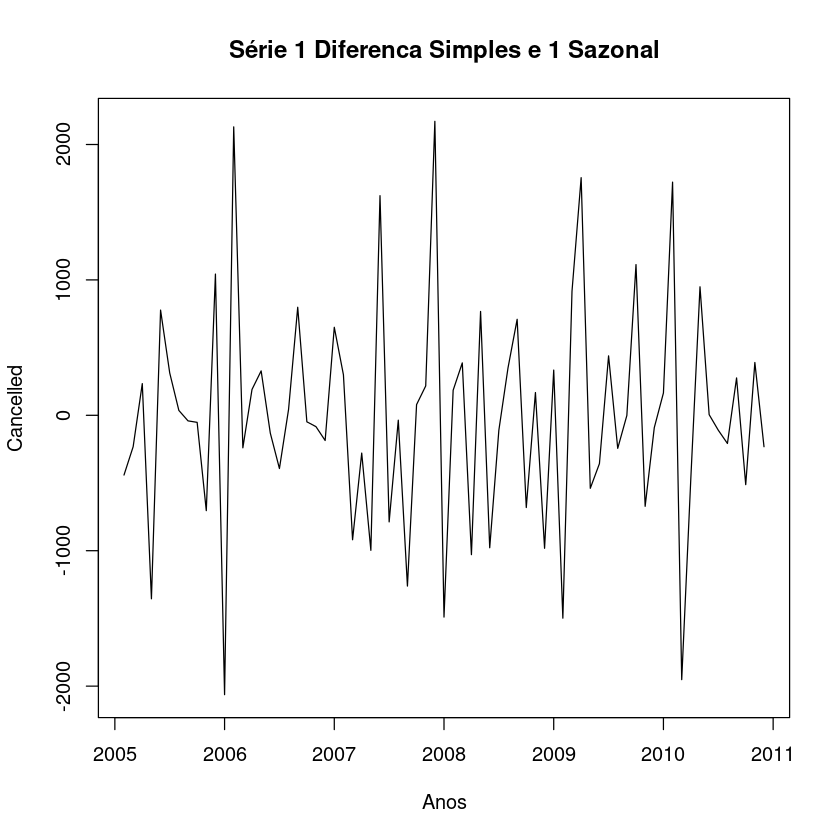

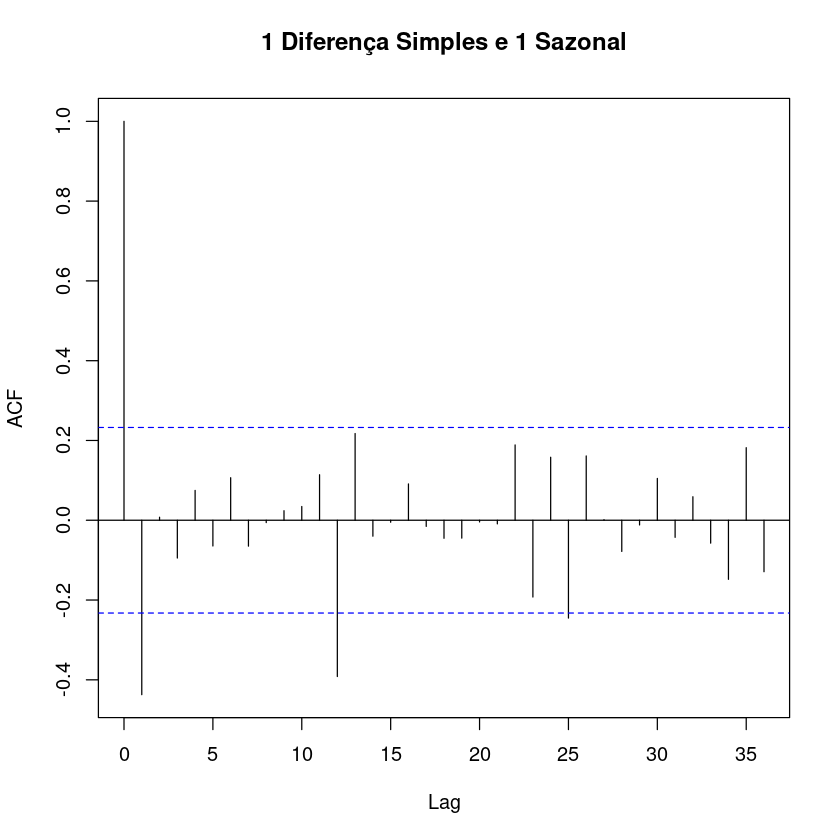

In [13]:
plot(diff(diff(Sbag),lag=12),main='Série 1 Diferenca Simples e 1 Sazonal',xlab='Anos',ylab=' Cancelled ')
min.m = acf(diff(diff(Sbag),lag=12), lag.max=36, plot=F, na.action=na.pass)
min.m$lag = min.m$lag*12
plot(min.m, main='1 Diferença Simples e 1 Sazonal')

### Diferenciação Sazonal
- ACF: Relação de uma série consigo mesma em lags diferentes. Picos são lags.
- PACF: O mesmo, removendo os efeitos de lags anteriores.

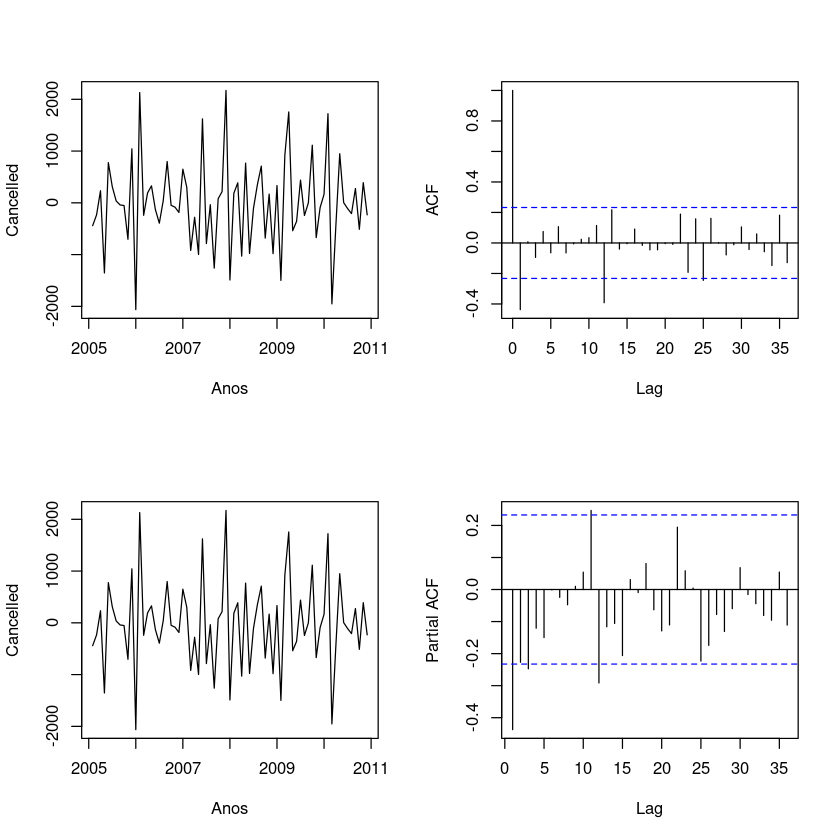

In [14]:
par(mfrow=c(2,2))
plot(diff(diff(Sbag),lag=12),main='',xlab='Anos',ylab=' Cancelled ')
min.m = acf(diff(diff(Sbag),lag=12), lag.max=36, plot=F, na.action=na.pass)
min.m$lag = min.m$lag*12
plot(min.m, main='')
plot(diff(diff(Sbag),lag=12),main='',xlab='Anos',ylab='Cancelled')
pmin.m = pacf(diff(diff(Sbag),lag=12), lag.max=36, plot=F, na.action=na.pass)
pmin.m$lag = pmin.m$lag*12
plot(pmin.m, main='')

**Ambos ACF e PACF exibem picos nos primeiros lags: um modelo ARMA pode ser apropriado.**

- p: termo da parte autoregressiva
   - Número de valores da FACP que estiverem acima do valor de confiança será considerado o valor máximo que **p** poderá atingir
- q: ordem da parte de média móvel
   - Número de valores da FAC que estiverem acima do seu intervalo de confiança.
Considerado o valor máximo que **q** poderá atingir
- d: número de diferenciações realizadas para estacionarizar os dados

# Modelo ARIMA

In [15]:
m1 = arima(Sbag,order=c(1,1,1),include.mean=F)
m1# determina para o modelo os coeficientes de p(AR) e q(Ma)


Call:
arima(x = Sbag, order = c(1, 1, 1), include.mean = F)

Coefficients:
         ar1      ma1
      0.2292  -0.9004
s.e.  0.1336   0.0634

sigma^2 estimated as 449766:  log likelihood = -658.58,  aic = 1323.17

# Modelo SARIMA

In [16]:
m2=arima(x = Sbag, order = c(1, 1, 1), seasonal = list(order = c(1, 1, 1)))
m2# determina para o modelo os coeficientes de p(AR) e q(Ma) da parte sazonal


Call:
arima(x = Sbag, order = c(1, 1, 1), seasonal = list(order = c(1, 1, 1)))

Coefficients:
          ar1      ma1    sar1     sma1
      -0.0575  -0.7177  0.0205  -0.6660
s.e.   0.1743   0.1219  0.2261   0.2727

sigma^2 estimated as 342021:  log likelihood = -556.86,  aic = 1123.71

# Diagnósticos

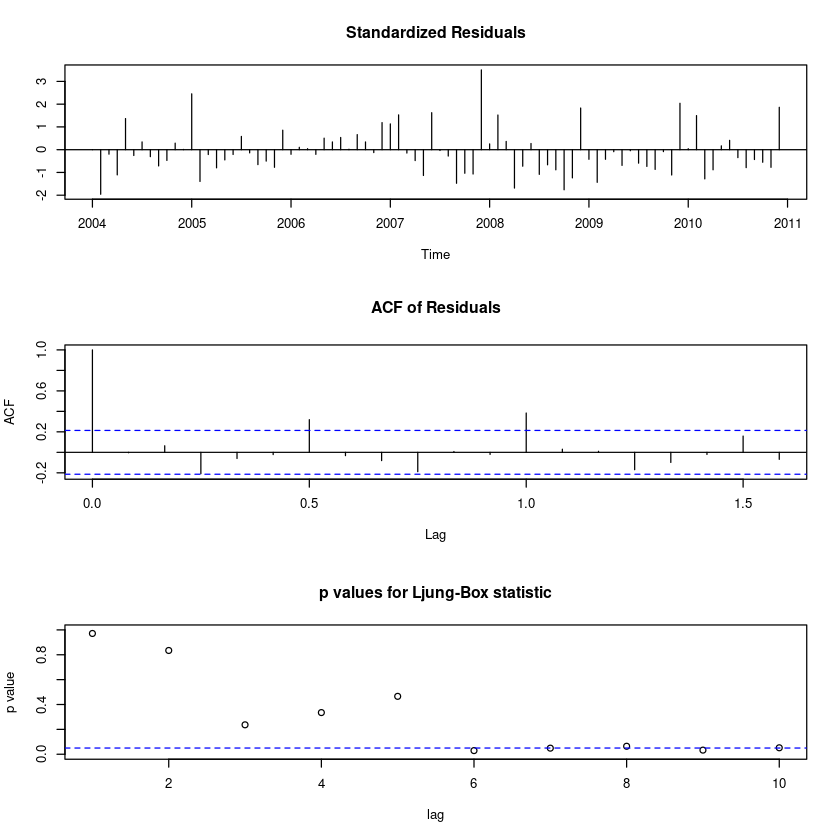

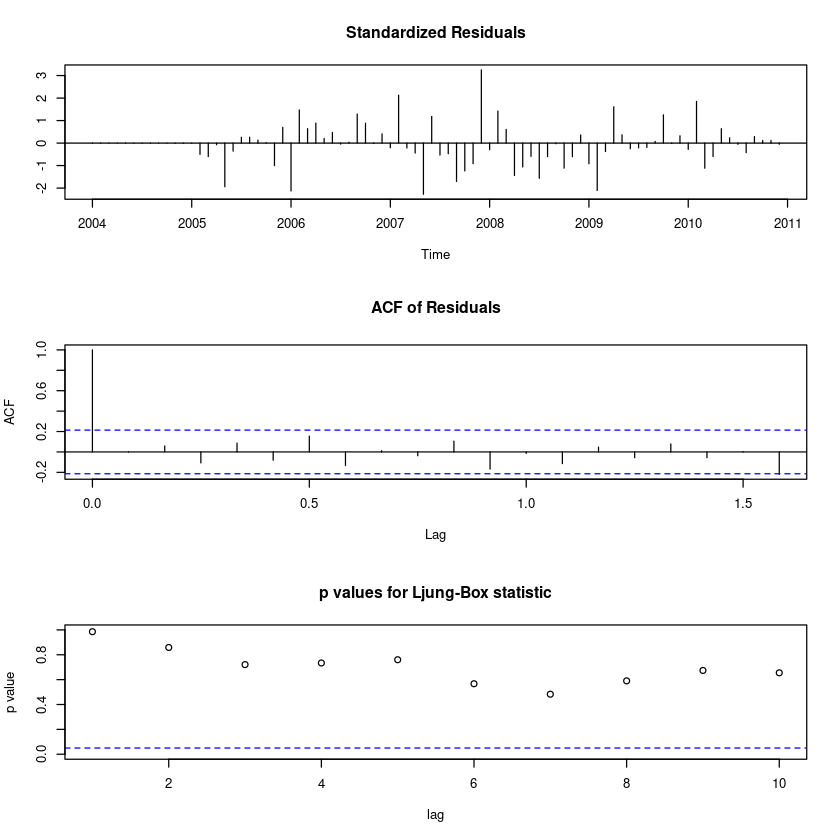

In [17]:
tsdiag(m1)# diagnostico ARIMA
tsdiag(m2)# diagnostico SARIMA

# Análise dos resíduos após induzir estacionaridade

### ARIMA


	Shapiro-Wilk normality test

data:  z
W = 0.94274, p-value = 0.0009825



	Box-Pierce test

data:  m1$residuals
X-squared = 0.0012389, df = 1, p-value = 0.9719


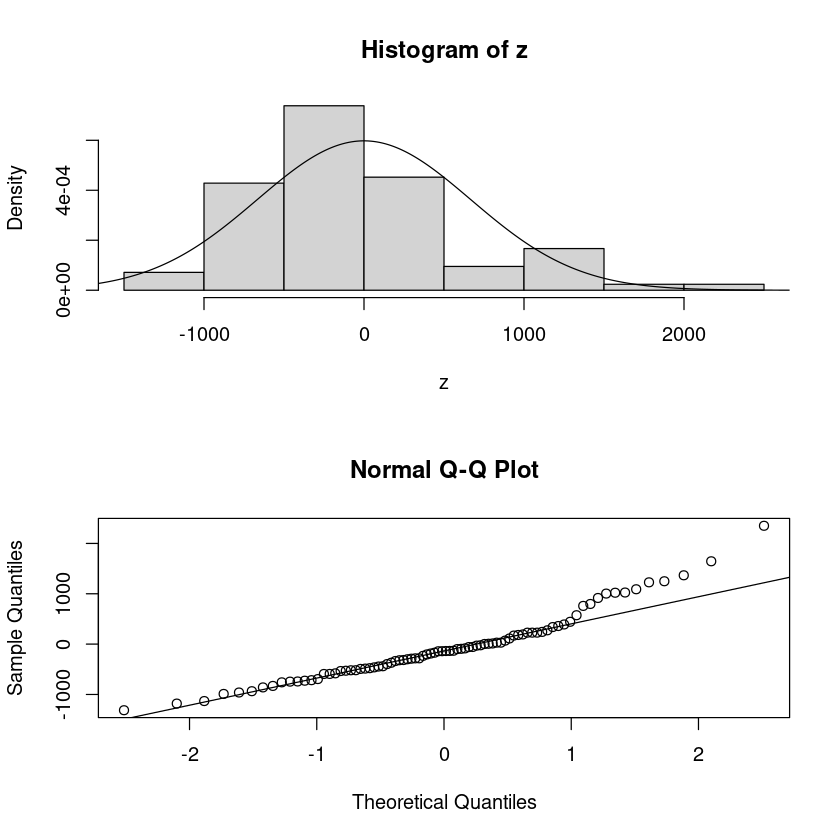

In [18]:
par(mfrow=c(2,1))
z=m1$residuals
hist(z,freq=F)
d = seq(range(z)[1]-3*sd(z),range(z)[2]+3*sd(z),0.001)
lines(d,dnorm(d,0,sd(z)))
qqnorm(z)
qqline(z)
#Teste de normalidade Shapiro-Wilk
shapiro.test(z)
#The BoxPierce (and LjungBox)
Box.test(m1$residuals,lag=1)# para ARIMA

### SARIMA

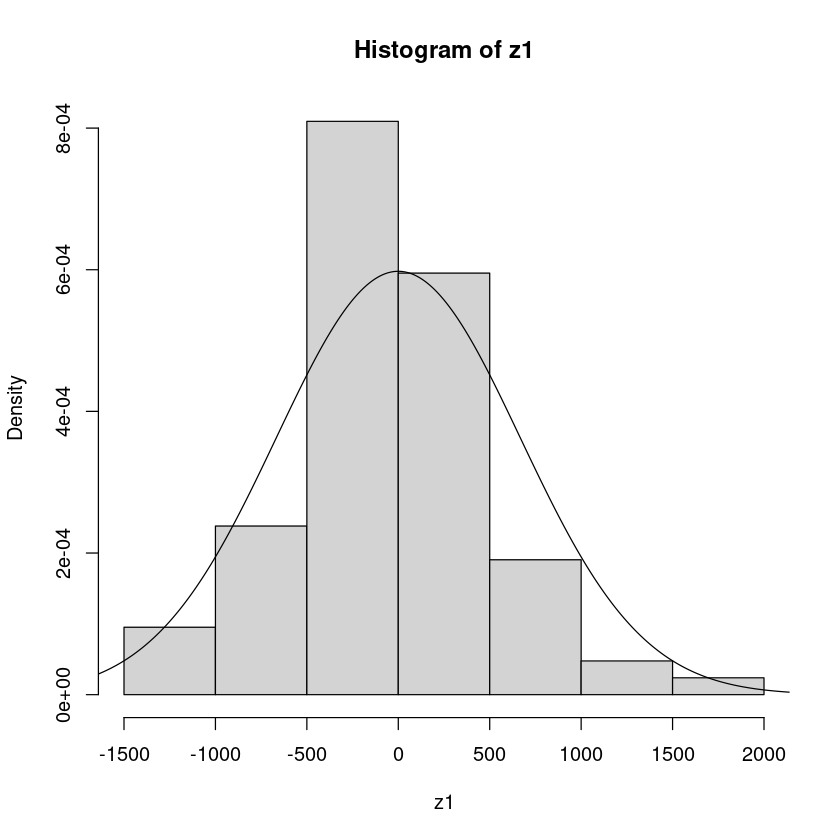


	Shapiro-Wilk normality test

data:  z1
W = 0.94613, p-value = 0.001531



	Box-Pierce test

data:  m2$residuals
X-squared = 0.00030425, df = 1, p-value = 0.9861


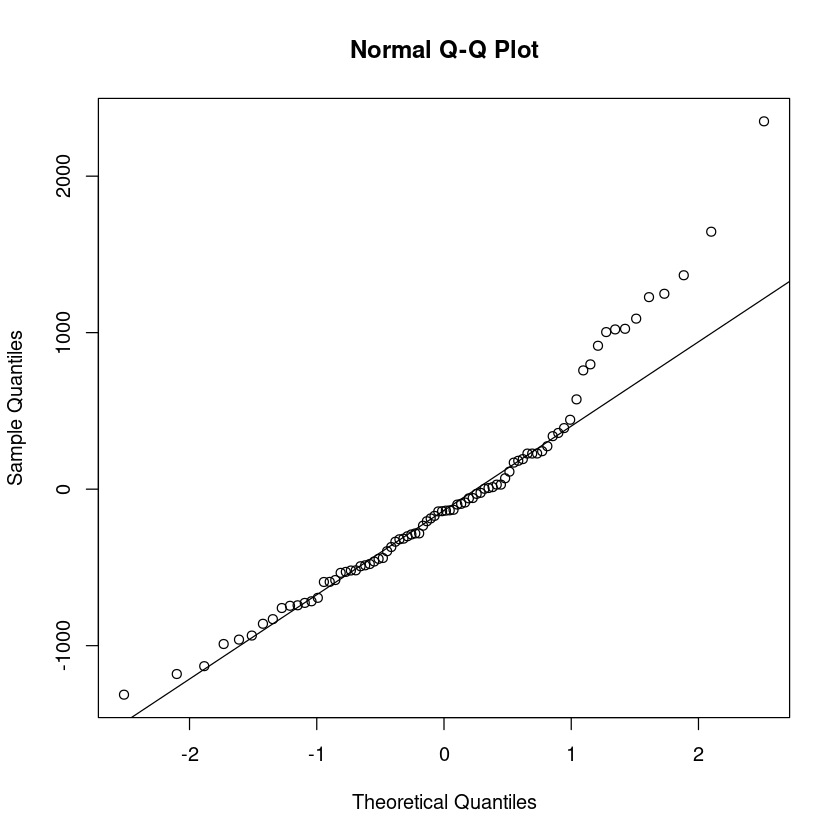

In [19]:
z1=m2$residuals
hist(z1,freq=F)
d1 = seq(range(z1)[1]-3*sd(z1),range(z1)[2]+3*sd(z1),0.001)
lines(d1,dnorm(d1,0,sd(z)))
qqnorm(z)
qqline(z)
#Teste de normalidade Shapiro-Wilk
shapiro.test(z1)
#Teste da idependencia dos residuos
#The BoxPierce (and LjungBox)
Box.test(m2$residuals,lag=1)# para SARIMA

# Previsões

### ARIMA

- Data mínima escolhida foi a máxima da série, data máxima foi 10 anos depois

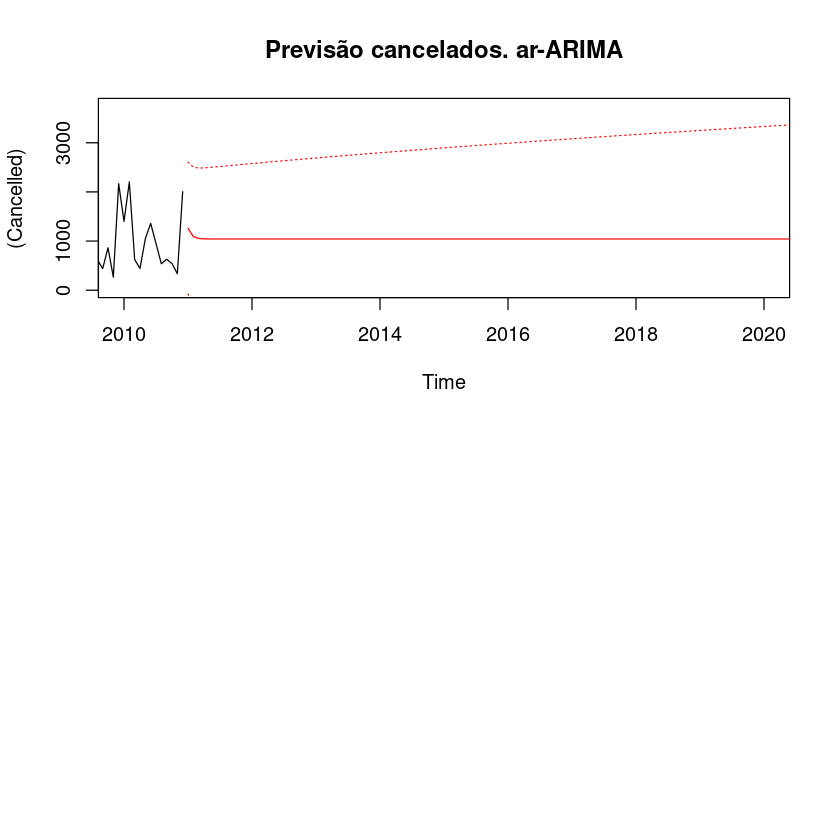

In [42]:
par(mfrow=c(2,1))
plot(Sbag,main="Previsão cancelados. ar-ARIMA", ylab="(Cancelled)", xlim=c(max(Year),2020),ylim=c(min(Cancelled),max(Cancelled) + 40))
pred1<-predict(m1,n.ahead=240)
lines(pred1$pred,col="red")
lines(pred1$pred+2*pred1$se,col="red",lty=3)
lines(pred1$pred-2*pred1$se,col="red",lty=3)

- Linha sólida representa predições para datas futuras.
- Linha tracejada representa incerteza na previsão.
- Vê se que há a previsão de redução brusca em vôos cancelados e uma possível redução leve
com o passar do tempo, mas a incerteza aumenta cada vez mais.

### SARIMA

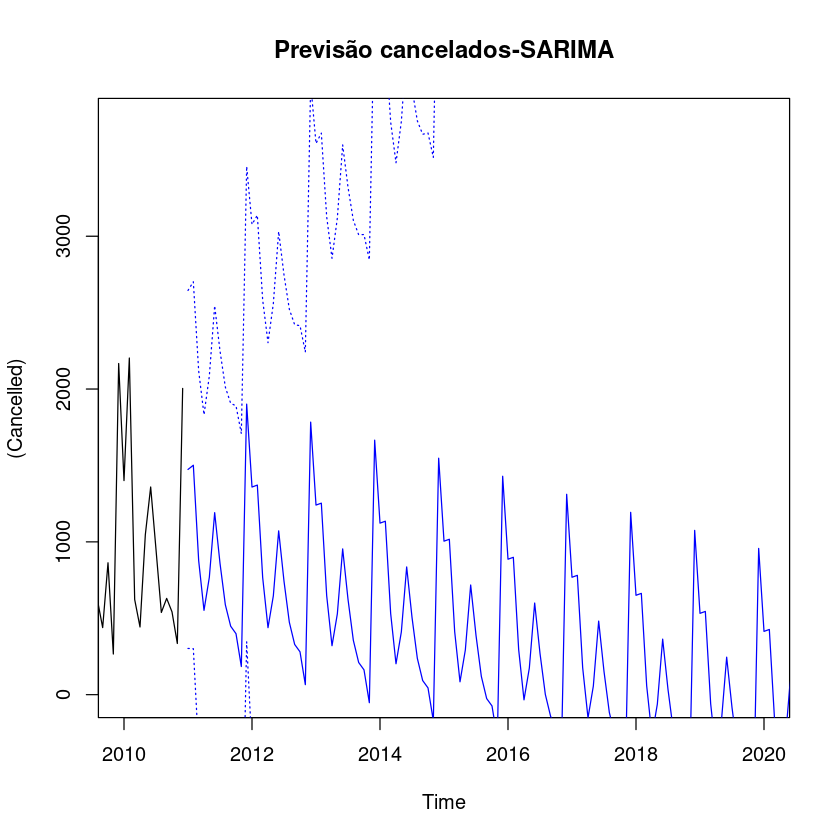

In [45]:
plot(Sbag,main="Previsão cancelados-SARIMA",ylab="(Cancelled)", xlim=c(max(Year),2020),ylim=c(min(Cancelled),max(Cancelled) + 40))
pred1<-predict(m2,n.ahead=240)
lines(pred1$pred,col="blue")
lines(pred1$pred+2*pred1$se,col="blue",lty=3)
lines(pred1$pred-2*pred1$se,col="blue",lty=3)

Referências
> https://arxiv.org/pdf/2009.05894